In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
class eca_layer(nn.Module):
    """Constructs a ECA module.
    Args:
        channel: Number of channels of the input feature map
        k_size: Adaptive selection of kernel size
    """
    def __init__(self, channel, k_size=3):
        super(eca_layer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.conv = nn.Conv1d(20, 20, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, h_reshaped, encoder_states):
        x = encoder_states
        x = x.transpose(0,1)
        h_reshaped = h_reshaped.transpose(0,1)
        attention_input = torch.cat((h_reshaped, x), dim=2)
        # feature descriptor on the global spatial information
        y = self.avg_pool(attention_input)

        # Two different branches of ECA module
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)

        # Multi-scale information fusion
        y = self.sigmoid(y)
        output = x * y.expand_as(x)
        output = output.transpose(0,1)

        return output

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True)

        self.fc_hidden = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_cell = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        # x: (seq_length, N) where N is batch size

        embedding = self.dropout(x)
        # embedding shape: (seq_length, N, embedding_size)

        encoder_states, (hidden, cell) = self.rnn(embedding)
        # outputs shape: (seq_length, N, hidden_size)

        # Use forward, backward cells and hidden through a linear layer
        # so that it can be input to the decoder which is not bidirectional
        # Also using index slicing ([idx:idx+1]) to keep the dimension
        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
        cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))

        return encoder_states, hidden, cell

In [4]:
class Decoder(nn.Module):
    def __init__(
        self, input_size, hidden_size, output_size, num_layers, p
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(hidden_size * 2, hidden_size, num_layers)

        self.attention = eca_layer(64)
        self.energy = nn.Linear(hidden_size * 3, 1)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p)
        self.softmax = nn.Softmax(dim=0)
        self.relu = nn.ReLU()

    def forward(self, encoder_states, hidden, cell):

        sequence_length = encoder_states.shape[0]
        h_reshaped = hidden.repeat(sequence_length, 1, 1)
        # h_reshaped: (seq_length, N, hidden_size*2)

        context_vector = self.attention(h_reshaped, encoder_states)

        rnn_input = context_vector
        # rnn_input: (1, N, hidden_size*2 + embedding_size)

        outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        # outputs shape: (1, N, hidden_size)

        predictions = self.fc(outputs).squeeze(0)
        # predictions: (N, hidden_size)

        return predictions, hidden, cell

In [5]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.flatten = nn.Flatten()
        self.final_layer = nn.Linear(20*22, 1)

    def forward(self, source, teacher_force_ratio=0.5):
        source = source.transpose(0,1)
        batch_size = source.shape[1]
        target_len = source.shape[0]
        target_vocab_size = 22

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
        encoder_states, hidden, cell = self.encoder(source)

        # At every time step use encoder_states and update hidden, cell
        output, hidden, cell = self.decoder(encoder_states, hidden, cell)

        # Store prediction for current time step
        outputs = output
            
        outputs = outputs.transpose(0,1)
        outputs = self.flatten(outputs)
        outputs = self.final_layer(outputs)

        return outputs

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder_net = Encoder(
    input_size=22,  
    hidden_size=32, 
    num_layers=1, 
    p=0
).to(device)

decoder_net = Decoder(
    input_size=22,
    hidden_size=32,
    output_size=22,
    num_layers=1,
    p=0,
).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)

In [7]:
x = torch.randn(5, 20, 22).to(device=device)
y = model(x,x)
print(y.shape)
print(y)

torch.Size([5, 1])
tensor([[-0.0551],
        [-0.0724],
        [-0.0792],
        [-0.0697],
        [-0.0625]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [9]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)

In [10]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [11]:
df_for_training=df[feature_names].astype(float)

In [12]:
df_for_training.shape

(11524, 22)

In [13]:
scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [14]:
trainX=[]
trainY=[]

In [15]:
n_future=1
n_past=20

In [16]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [17]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [18]:
trainX_copy,trainY_copy=trainX.copy(),trainY.copy()

In [19]:
def random_shuffle(data,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data,label

In [20]:
data,label=random_shuffle(trainX,trainY)

In [21]:
# Create a DataLoader for the training data
data = torch.from_numpy(data).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data, label)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [23]:
for epoch in range(1000):
    losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        #output = model(data1, data2)
        output = model(data)
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())
    
    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.15324799716472626
Epoch: 1 Loss: 0.056815922260284424
Epoch: 2 Loss: 0.03142453357577324
Epoch: 3 Loss: 0.08674667775630951
Epoch: 4 Loss: 0.08907198905944824
Epoch: 5 Loss: 0.0241788849234581
Epoch: 6 Loss: 0.02310609258711338
Epoch: 7 Loss: 0.09384879469871521
Epoch: 8 Loss: 0.1232919692993164
Epoch: 9 Loss: 0.22919970750808716
Epoch: 10 Loss: 0.07285525649785995
Epoch: 11 Loss: 0.06995608657598495
Epoch: 12 Loss: 0.08727563917636871
Epoch: 13 Loss: 0.028179435059428215
Epoch: 14 Loss: 0.08993055671453476
Epoch: 15 Loss: 0.028667205944657326
Epoch: 16 Loss: 0.020424794405698776
Epoch: 17 Loss: 0.04648575186729431
Epoch: 18 Loss: 0.07755754142999649
Epoch: 19 Loss: 0.03952644765377045
Epoch: 20 Loss: 0.025356415659189224
Epoch: 21 Loss: 0.030230076983571053
Epoch: 22 Loss: 0.04888182505965233
Epoch: 23 Loss: 0.04491671174764633
Epoch: 24 Loss: 0.03576212376356125
Epoch: 25 Loss: 0.15343722701072693
Epoch: 26 Loss: 0.023867513984441757
Epoch: 27 Loss: 0.036089342087507

Epoch: 222 Loss: 0.043819788843393326
Epoch: 223 Loss: 0.0134067228063941
Epoch: 224 Loss: 0.01733960397541523
Epoch: 225 Loss: 0.006589795462787151
Epoch: 226 Loss: 0.011113788932561874
Epoch: 227 Loss: 0.015670171007514
Epoch: 228 Loss: 0.020312422886490822
Epoch: 229 Loss: 0.017837513238191605
Epoch: 230 Loss: 0.016919732093811035
Epoch: 231 Loss: 0.014168092980980873
Epoch: 232 Loss: 0.05046343058347702
Epoch: 233 Loss: 0.03236003592610359
Epoch: 234 Loss: 0.021410290151834488
Epoch: 235 Loss: 0.015028472989797592
Epoch: 236 Loss: 0.009034589864313602
Epoch: 237 Loss: 0.015846628695726395
Epoch: 238 Loss: 0.016521548852324486
Epoch: 239 Loss: 0.016710547730326653
Epoch: 240 Loss: 0.00780851487070322
Epoch: 241 Loss: 0.01351252943277359
Epoch: 242 Loss: 0.020384546369314194
Epoch: 243 Loss: 0.015682445839047432
Epoch: 244 Loss: 0.019307367503643036
Epoch: 245 Loss: 0.023890171200037003
Epoch: 246 Loss: 0.0330946184694767
Epoch: 247 Loss: 0.007948153652250767
Epoch: 248 Loss: 0.01398

Epoch: 440 Loss: 0.013878419995307922
Epoch: 441 Loss: 0.005912710912525654
Epoch: 442 Loss: 0.011993590742349625
Epoch: 443 Loss: 0.013742292299866676
Epoch: 444 Loss: 0.019990243017673492
Epoch: 445 Loss: 0.00575866736471653
Epoch: 446 Loss: 0.018640074878931046
Epoch: 447 Loss: 0.008014686405658722
Epoch: 448 Loss: 0.0072121755219995975
Epoch: 449 Loss: 0.03141479566693306
Epoch: 450 Loss: 0.02178572490811348
Epoch: 451 Loss: 0.012266300618648529
Epoch: 452 Loss: 0.02426031604409218
Epoch: 453 Loss: 0.012616459280252457
Epoch: 454 Loss: 0.02069498598575592
Epoch: 455 Loss: 0.012683447450399399
Epoch: 456 Loss: 0.031255461275577545
Epoch: 457 Loss: 0.013953404501080513
Epoch: 458 Loss: 0.027084246277809143
Epoch: 459 Loss: 0.005286522209644318
Epoch: 460 Loss: 0.00460089510306716
Epoch: 461 Loss: 0.013471575453877449
Epoch: 462 Loss: 0.017269616946578026
Epoch: 463 Loss: 0.003674922976642847
Epoch: 464 Loss: 0.022038649767637253
Epoch: 465 Loss: 0.012444265186786652
Epoch: 466 Loss: 

Epoch: 658 Loss: 0.003103365655988455
Epoch: 659 Loss: 0.008431912399828434
Epoch: 660 Loss: 0.007692535407841206
Epoch: 661 Loss: 0.03529293090105057
Epoch: 662 Loss: 0.013063875958323479
Epoch: 663 Loss: 0.004590138327330351
Epoch: 664 Loss: 0.009717672131955624
Epoch: 665 Loss: 0.009432291612029076
Epoch: 666 Loss: 0.006764407269656658
Epoch: 667 Loss: 0.010037579573690891
Epoch: 668 Loss: 0.00695875845849514
Epoch: 669 Loss: 0.013015387579798698
Epoch: 670 Loss: 0.012766672298312187
Epoch: 671 Loss: 0.009329117834568024
Epoch: 672 Loss: 0.007287046872079372
Epoch: 673 Loss: 0.010309796780347824
Epoch: 674 Loss: 0.014663728885352612
Epoch: 675 Loss: 0.010912541300058365
Epoch: 676 Loss: 0.012425849214196205
Epoch: 677 Loss: 0.007219836115837097
Epoch: 678 Loss: 0.011660227552056313
Epoch: 679 Loss: 0.014149252325296402
Epoch: 680 Loss: 0.006692009046673775
Epoch: 681 Loss: 0.017927484586834908
Epoch: 682 Loss: 0.014152668416500092
Epoch: 683 Loss: 0.01669432781636715
Epoch: 684 Loss

Epoch: 875 Loss: 0.006561702117323875
Epoch: 876 Loss: 0.002582905348390341
Epoch: 877 Loss: 0.017101842910051346
Epoch: 878 Loss: 0.009503613226115704
Epoch: 879 Loss: 0.011849535629153252
Epoch: 880 Loss: 0.007571461610496044
Epoch: 881 Loss: 0.00782514177262783
Epoch: 882 Loss: 0.005800649989396334
Epoch: 883 Loss: 0.007497691549360752
Epoch: 884 Loss: 0.005312067456543446
Epoch: 885 Loss: 0.00973475631326437
Epoch: 886 Loss: 0.008473837748169899
Epoch: 887 Loss: 0.018902217969298363
Epoch: 888 Loss: 0.01594461500644684
Epoch: 889 Loss: 0.01379803754389286
Epoch: 890 Loss: 0.010234823450446129
Epoch: 891 Loss: 0.0043901242315769196
Epoch: 892 Loss: 0.01023909542709589
Epoch: 893 Loss: 0.008099891245365143
Epoch: 894 Loss: 0.012319134548306465
Epoch: 895 Loss: 0.002800864167511463
Epoch: 896 Loss: 0.004827224183827639
Epoch: 897 Loss: 0.018647069111466408
Epoch: 898 Loss: 0.008452732115983963
Epoch: 899 Loss: 0.009019310586154461
Epoch: 900 Loss: 0.014682434499263763
Epoch: 901 Loss:

In [24]:
test_data = torch.from_numpy(trainX_copy).float()
test_label = torch.from_numpy(trainY_copy).float()
test_dataset = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [25]:
predictions=[]
for batch_idx, (data, targets) in enumerate(test_loader):
    data = data.to(device=device)
    output = model(data)
    targets = targets.to(device=device)
    predictions+=output.tolist()

In [26]:
predictions = np.array(predictions)

In [27]:
predict_copies1 = np.repeat(predictions[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1) 
predict_1 = scaler.inverse_transform(predict_copies1)[:,21]

In [28]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

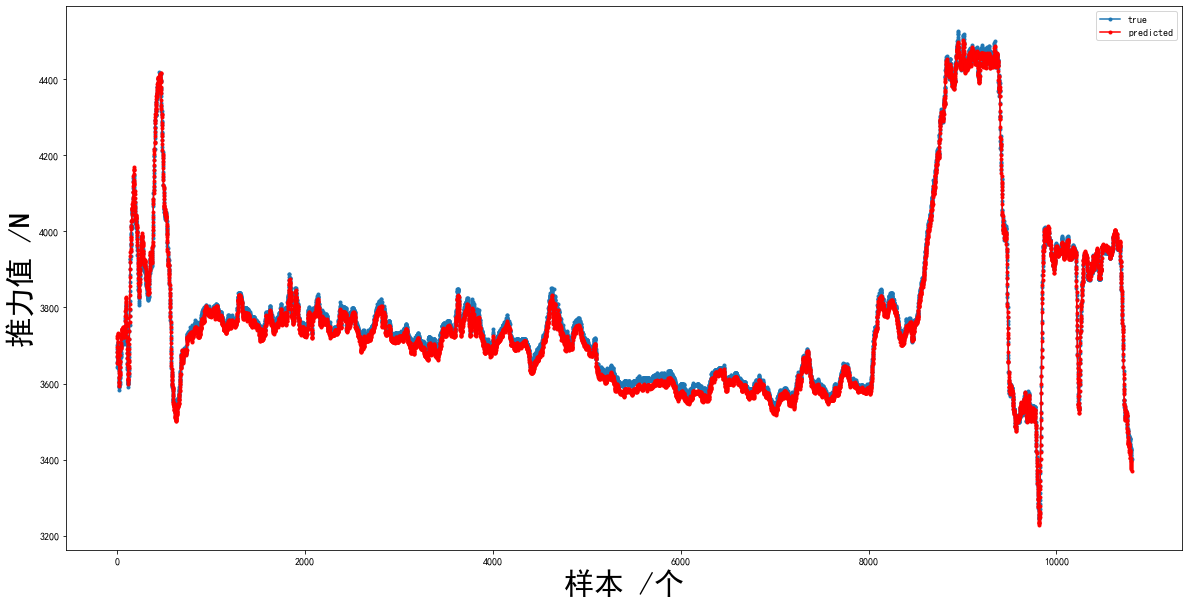

In [29]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot(predict_1[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend();